# **TP09 - Modelo de lenguaje y Sistemas de Recomendación**

In [28]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import io
import zipfile
import requests



## **Lectura de datos**

Lo primero que tenemos que hacer es cargar la base de datos correspondiente. En este caso la base de datos la obtenemos del archivo `movies.csv` que se encuentra en el Github de la materia.

El código realiza lo siguiente:

- `url`: contiene la dirección directa al archivo CSV alojado en un repositorio de GitHub.
- `pd.read_csv(url)`: carga el archivo CSV desde la URL y lo convierte en un `DataFrame`, una estructura tabular de la biblioteca `pandas` muy útil para análisis de datos.
- `df_movies.head().to_markdown()`: muestra las primeras filas del DataFrame en formato Markdown para facilitar la visualización en entornos como Jupyter o en reportes.

El DataFrame resultante representa una matriz de interacciones usuario-película, donde:

- Cada **fila** corresponde a una **película**.
- Cada **columna** representa un **usuario**.
- Cada celda contiene información sobre la interacción del usuario con la película, es decir, que calificación le da el usuario a la pelicula, la calificación es un número entre 1 y 5, y puede ser 0 en caso de que el usuario todavía no haya calificado la pelicula.

In [20]:

# URL del archivo CSV en formato "raw" (crudo)
url = 'https://raw.githubusercontent.com/mvera1412/TA136-TB056-TB057-8625/refs/heads/main/data/movies.csv'

# Leer el archivo CSV directamente desde GitHub
df_movies = pd.read_csv(url)

# Mostrar las primeras filas del DataFrame
print(df_movies.head().to_markdown())


|    | Name              |   user_0 |   user_1 |   user_2 |   user_3 |   user_4 |   user_5 |   user_6 |   user_7 |   user_8 |   user_9 |   user_10 |   user_11 |   user_12 |   user_13 |   user_14 |   user_15 |   user_16 |   user_17 |   user_18 |   user_19 |   user_20 |   user_21 |   user_22 |   user_23 |   user_24 |   user_25 |   user_26 |   user_27 |   user_28 |   user_29 |   user_30 |   user_31 |   user_32 |   user_33 |   user_34 |   user_35 |   user_36 |   user_37 |   user_38 |   user_39 |   user_40 |   user_41 |   user_42 |   user_43 |   user_44 |   user_45 |   user_46 |   user_47 |   user_48 |   user_49 |   user_50 |   user_51 |   user_52 |   user_53 |   user_54 |   user_55 |   user_56 |   user_57 |   user_58 |   user_59 |   user_60 |   user_61 |   user_62 |   user_63 |   user_64 |   user_65 |   user_66 |   user_67 |   user_68 |   user_69 |   user_70 |   user_71 |   user_72 |   user_73 |   user_74 |   user_75 |   user_76 |   user_77 |   user_78 |   user_79 |   user_80 |   user_81 |

## **Carga del modelo de lenguaje GloVe**

En esta parte del trabajo se carga un modelo de lenguaje preentrenado basado en GloVe (*Global Vectors for Word Representation*), una técnica que permite representar palabras como vectores numéricos en un espacio semántico.

El archivo `glove.6B.300d.txt` contiene vectores de 300 dimensiones para un vocabulario extenso. Se lee línea por línea, separando la palabra del vector correspondiente. Cada vector se guarda como un `numpy array`, y se construye un diccionario donde las claves son palabras y los valores son sus vectores.

Para ello:

- Se abre el archivo con codificación `utf-8`.
- Cada línea se separa en partes: la primera es la palabra, las siguientes 300 son los valores numéricos del vector.
- Se convierte ese fragmento numérico en un `np.array` de tipo `float`.
- Se guarda la entrada en un diccionario llamado `language_model`.

Este modelo permite capturar relaciones semánticas entre palabras y se puede utilizar para:

- Calcular similitud entre términos.
- Representar texto como vectores para clasificación, agrupamiento o recomendaciones.
- Construir sistemas de recomendación basados en contenido textual.


In [29]:
# URL del archivo GloVe
url = 'http://nlp.stanford.edu/data/glove.6B.zip'

# Descarga del ZIP en memoria
print("Descargando GloVe...")
resp = requests.get(url)
resp.raise_for_status()
zip_buf = io.BytesIO(resp.content)
print("Descarga completa")



Descargando GloVe...
Descarga completa


In [30]:
# Inicializamos el diccionario
language_model = {}

# Leemos el archivo glove.6B.300d.txt desde el ZIP
print("Cargando embeddings glove.6B.300d.txt...")
with zipfile.ZipFile(zip_buf) as z:
    with z.open('glove.6B.300d.txt') as f:
        for line in f:
            parts = line.decode('utf-8').strip().split()
            word = parts[0]
            vec = np.array(parts[1:], dtype=float)
            language_model[word] = vec

print(f"Modelo cargado: {len(language_model):,} palabras.")


Cargando embeddings glove.6B.300d.txt...
Modelo cargado: 400,000 palabras.


## **Buscador de películas**

En esta sección se define una clase `BuscadorPeliculas` que permite buscar películas a partir de una consulta en lenguaje natural. Para lograrlo, se usan **embeddings de palabras** obtenidos del modelo de lenguaje GloVe.

La idea central es convertir tanto los títulos de películas como la consulta del usuario en vectores, y luego buscar el título más similar usando la **similitud coseno**.

### Estructura de la clase

La clase recibe:

- `titulos_peliculas`: una lista con los nombres de las películas.
- `modelo_lenguaje`: un diccionario que asocia cada palabra a su vector GloVe.
- `dimension`: la dimensión de los vectores (300 por defecto).

Durante la inicialización, se convierte cada título en un vector mediante una función de tipo "bolsa de palabras".

### Métodos principales

- `word2vec(palabra)`: devuelve el vector correspondiente a una palabra. Si no está en el vocabulario, retorna un vector nulo.
  
- `bolsa_de_palabras(texto)`: transforma un texto en un vector promedio. Este vector representa el título completo o la consulta del usuario. El procesamiento incluye:

  1. **Minúsculas**: convierte todo el texto a minúsculas para evitar que la capitalización afecte la comparación.
  2. **Remoción de símbolos**: elimina caracteres no alfanuméricos como signos de puntuación.
  3. **Espacios extra**: normaliza múltiples espacios consecutivos a uno solo.
  4. **Separación por palabras**: divide el texto en palabras individuales.
  5. **Conversión a vectores**: convierte cada palabra en su vector GloVe correspondiente.
  6. **Promedio**: calcula el promedio de los vectores individuales para obtener un único vector que representa el texto completo.

  Por ejemplo:
  Supongamos que el título es `"Toy Story (1995)"`. El procesamiento se hace así:

  - Se convierte a minúsculas: `"toy story (1995)"`
  - Se eliminan símbolos no alfanuméricos: `"toy story 1995"`
  - Se remueven espacios extra (en este caso no aplica)
  - Se divide en palabras: `["toy", "story", "1995"]`
  - Cada palabra se convierte en un vector, y luego se promedian para formar un único vector de dimensión 300.

  Este vector es el que se usará para comparar contra otros títulos o contra la consulta del usuario.

  
- `similitud_coseno(u, v)`: calcula la similitud entre dos vectores usando el coseno del ángulo entre ellos. Esta métrica se define como:

  $$
  \text{sim}(u, v) = \frac{u \cdot v}{\|u\| \cdot \|v\|}
  $$

  Donde $ u \cdot v $ es el producto punto entre los vectores, y $ \|u\| $ y $ \|v\| $ son sus normas (magnitudes). Si alguno de los vectores es nulo (norma cero), la similitud se define como cero.

- `buscar(consulta)`: convierte la consulta en un vector y lo compara con todos los vectores de títulos. Devuelve el título más similar y su puntuación de similitud.

### Aplicación práctica

Este buscador permite ofrecer recomendaciones o realizar búsquedas aproximadas, incluso cuando la consulta no coincide exactamente con los títulos. Por ejemplo, si el usuario escribe "space movie", puede devolver "Interstellar" aunque esas palabras no estén literalmente en el título, gracias al uso de **representaciones semánticas**.


In [31]:
class BuscadorPeliculas:
    def __init__(self, titulos_peliculas, modelo_lenguaje, dimension=300):
        self.modelo_lenguaje = modelo_lenguaje
        self.dimension = dimension
        self.titulos = titulos_peliculas
        self.embeddings_titulos = [self.bolsa_de_palabras(t) for t in self.titulos]

    def word2vec(self, palabra):
        return self.modelo_lenguaje.get(palabra, np.zeros(self.dimension))

    def bolsa_de_palabras(self, texto):
        texto = texto.lower()
        texto = re.sub(r'[^a-z0-9\s]', '', texto)
        texto = re.sub(r'\s+', ' ', texto).strip()
        palabras = texto.split()
        vectores = [self.word2vec(p) for p in palabras]
        return np.mean(vectores, axis=0) if vectores else np.zeros(self.dimension)

    def similitud_coseno(self, u, v):
        norma_u = np.linalg.norm(u)
        norma_v = np.linalg.norm(v)
        if norma_u == 0 or norma_v == 0:
            return 0.0
        return np.dot(u, v) / (norma_u * norma_v)

    def buscar(self, consulta):
        emb_consulta = self.bolsa_de_palabras(consulta)
        similitudes = [self.similitud_coseno(emb_consulta, emb_t) for emb_t in self.embeddings_titulos]
        indice_max = np.argmax(similitudes)
        return self.titulos[indice_max], similitudes[indice_max]
    

# Crear el buscador
buscador = BuscadorPeliculas(df_movies['Name'].tolist(), language_model)

# --- 🔹 Probar método word2vec ---
palabra = "toy"
vector_toy = buscador.word2vec(palabra)
print("Vector de 'toy' (primeras 5 componentes):", vector_toy[:5])

palabra_inexistente = "palabra_inexistente"
vector_inexistente = buscador.word2vec(palabra_inexistente)
print("Vector de palabra inexistente:", vector_inexistente[:5])

# --- 🔹 Probar método bolsa_de_palabras ---
frase = "Toy Story"
vector_bolsa = buscador.bolsa_de_palabras(frase)
print("\nVector de 'Toy Story' (primeras 5 componentes):", vector_bolsa[:5])

# --- 🔹 Probar método similitud_coseno ---
vector1 = buscador.bolsa_de_palabras("Toy Story")
vector2 = buscador.bolsa_de_palabras("copy cat")
sim_cos = buscador.similitud_coseno(vector1, vector2)
print("\nSimilitud coseno entre 'Toy Story' y 'copy cat':", sim_cos)

# --- 🔹 Probar método buscar ---
# Realizar una búsqueda
titulo, score = buscador.buscar("toy story")
print(f"Película sugerida: {titulo} (similitud: {score:.3f})")



Vector de 'toy' (primeras 5 componentes): [ 0.24882  0.34201 -0.3647  -0.42462 -0.49814]
Vector de palabra inexistente: [0. 0. 0. 0. 0.]

Vector de 'Toy Story' (primeras 5 componentes): [ 0.02109   0.102155 -0.237945 -0.43965  -0.11878 ]

Similitud coseno entre 'Toy Story' y 'copy cat': 0.39476603571397884
Película sugerida:  Toy Story (1995) (similitud: 0.904)


## **Agregar un nuevo usuario al sistema de recomendación**

Esta función permite simular la interacción de un nuevo usuario con el sistema de recomendación. A partir de una serie de **consultas escritas a mano** (que pueden contener errores tipográficos o ser diferentes a los títulos originales), y una lista de **calificaciones numéricas**, se agrega una nueva columna al `DataFrame` original. Cada fila representa una película, y cada columna un usuario, por lo que estamos agregando las preferencias personalizadas de este nuevo usuario.

La función `agregar_usuario()` funciona de la siguiente manera:

- Se crea una copia del `DataFrame` para evitar modificar el original.
- Se agrega una nueva columna (con el nombre del usuario) inicializada en cero, es decir, sin ninguna calificación asignada todavía.
- Luego se recorre cada consulta hecha por el usuario. Para cada una:
  - Se utiliza el objeto `BuscadorPeliculas` (definido anteriormente) para buscar el título más similar.
  - Si el título encontrado existe en el `DataFrame`, se coloca la calificación correspondiente en la fila adecuada.
  - Si no se encuentra, se imprime un mensaje de advertencia.

La función devuelve un nuevo `DataFrame` que incluye esta columna adicional con las calificaciones del usuario.


In [32]:
def agregar_usuario(df, buscador, nombre_usuario, consultas, calificaciones):
    """
    Agrega una nueva columna (usuario) con sus calificaciones al DataFrame donde las filas son películas.

    Args:
        df (pd.DataFrame): DataFrame con películas en filas y usuarios en columnas.
        buscador (BuscadorPeliculas): Objeto para buscar los títulos.
        nombre_usuario (str): Nombre/ID del nuevo usuario.
        consultas (list[str]): Lista de consultas escritas por el usuario.
        calificaciones (list[int]): Lista de calificaciones correspondientes.

    Returns:
        pd.DataFrame: DataFrame con una nueva columna agregada.
    """
    # Copia del DataFrame para no modificar el original
    df_actualizado = df.copy()

    # Crear nueva columna llena de ceros
    df_actualizado[nombre_usuario] = 0

    # Iterar sobre las consultas
    for consulta, calif in zip(consultas, calificaciones):
        titulo_encontrado, similitud = buscador.buscar(consulta)
        print(f"Consulta: '{consulta}' → Encontrado: '{titulo_encontrado}' (similitud: {similitud:.3f})")


        if titulo_encontrado in df_actualizado['Name'].values:  # Cambiá 'movie' si tu columna tiene otro nombre
            fila_idx = df_actualizado[df_actualizado['Name'] == titulo_encontrado].index[0]
            df_actualizado.at[fila_idx, nombre_usuario] = calif
        else:
            print(f"  ⚠️ ¡Aviso! Título '{titulo_encontrado}' no está en la columna de títulos.")


    return df_actualizado



# Consultas con errores y calificaciones
consultas_usuario = [
    "harry pottr", "the godfather", "lord of the rings", "matrix reloaded",
    "pulp ficton", "forrest gump", "star wars", "incepton", "gladiatr", "titanic"
]
calificaciones_usuario = [5, 5, 4, 4, 5, 5, 4, 4, 3, 5]

# Agregar al DataFrame
df_actualizado = agregar_usuario(df_movies, buscador, "usuario_nuevo", consultas_usuario, calificaciones_usuario)

# Verificar resultados
print(df_actualizado["usuario_nuevo"].value_counts())



Consulta: 'harry pottr' → Encontrado: ' Deconstructing Harry (1997)' (similitud: 0.768)
Consulta: 'the godfather' → Encontrado: ' Godfather, The (1972)' (similitud: 0.879)
Consulta: 'lord of the rings' → Encontrado: ' Lord of Illusions (1995)' (similitud: 0.790)
Consulta: 'matrix reloaded' → Encontrado: ' Amityville 3-D (1983)' (similitud: 0.284)
Consulta: 'pulp ficton' → Encontrado: ' Pulp Fiction (1994)' (similitud: 0.770)
Consulta: 'forrest gump' → Encontrado: ' Forrest Gump (1994)' (similitud: 0.922)
Consulta: 'star wars' → Encontrado: ' Star Wars (1977)' (similitud: 0.923)
Consulta: 'incepton' → Encontrado: ' Toy Story (1995)' (similitud: 0.000)
Consulta: 'gladiatr' → Encontrado: ' Toy Story (1995)' (similitud: 0.000)
Consulta: 'titanic' → Encontrado: ' Titanic (1997)' (similitud: 0.816)
usuario_nuevo
0    1673
5       5
4       3
3       1
Name: count, dtype: int64


# Filtro colaborativo

En el filtrado colaborativo mediante **factorización matricial**, el objetivo es aproximar la matriz de calificaciones $ Y \in \mathbb{R}^{n_{\text{items}} \times n_{\text{users}}} $ como el producto de dos matrices de menor dimensión:

$$
Y \approx X \Theta^\top
$$

- $ X \in \mathbb{R}^{n_{\text{items}} \times \nu} $: vectores latentes de los ítems (por ejemplo, películas).
- $ \Theta \in \mathbb{R}^{n_{\text{users}} \times \nu} $: vectores latentes de los usuarios.
- $ \nu $: dimensión del espacio latente (típicamente $ \nu \ll n_{\text{items}}, n_{\text{users}} $).

El entrenamiento consiste en minimizar una función de pérdida regularizada que penaliza tanto el error de predicción como la complejidad de los vectores:

$$
\min_{X, \Theta} \quad \frac{1}{2} \sum_{(i,j): y_{ij} > 0} \left( \theta_j^\top x_i - y_{ij} \right)^2 + \frac{\lambda}{2} \left( \sum_{i=1}^{n_{\text{items}}} \|x_i\|^2 + \sum_{j=1}^{n_{\text{users}}} \|\theta_j\|^2 \right)
$$

- El primer término mide el error cuadrático en las observaciones reales.
- El segundo es la **regularización L2**, que penaliza vectores grandes y reduce el overfitting.
- $ \lambda \geq 0 $: hiperparámetro de regularización.


Para minimizar la función de pérdida usamos **descenso por gradiente**. Los gradientes de la función con respecto a los parámetros son:

### Gradiente respecto a los vectores de ítem $ x_i $:

$$
\frac{\partial J}{\partial x_i} = \sum_{j: y_{ij} > 0} \left( \theta_j^\top x_i - y_{ij} \right) \theta_j + \lambda x_i
$$

### Gradiente respecto a los vectores de usuario $ \theta_j $:

$$
\frac{\partial J}{\partial \theta_j} = \sum_{i: y_{ij} > 0} \left( \theta_j^\top x_i - y_{ij} \right) x_i + \lambda \theta_j
$$


En cada iteración se actualizan los parámetros de la siguiente forma:

$$
x_i \leftarrow x_i - \eta \cdot \frac{\partial J}{\partial x_i}
\qquad
\theta_j \leftarrow \theta_j - \eta \cdot \frac{\partial J}{\partial \theta_j}
$$

donde $ \eta $ es la tasa de aprendizaje.

---

## ✅ Implementación en Código

Se implementa una única función principal `entrenar_filtrado_colaborativo`:

Esta función implementa el **entrenamiento de un sistema de recomendación basado en filtrado colaborativo** utilizando el enfoque de **factorización matricial** con **descenso por gradiente** y **regularización L2**. El objetivo es aprender representaciones vectoriales (embeddings) tanto para los ítems como para los usuarios, de forma que se pueda aproximar la matriz de calificaciones observadas $ Y $.

El sistema busca aproximar la matriz de calificaciones como el producto de dos matrices de menor dimensión:

$$
Y \approx X \Theta^\top
$$

donde:
- $ X \in \mathbb{R}^{n_{\text{items}} \times \nu} $: representa a los ítems en un espacio latente.
- $ \Theta \in \mathbb{R}^{n_{\text{users}} \times \nu} $: representa a los usuarios en ese mismo espacio.
- $ \nu $: dimensión del espacio latente (embedding size).

#### ⚙️ Descripción paso a paso del código

1. **Inicialización de parámetros**
   - Se crean matrices `X` (embeddings de ítems) y `Theta` (embeddings de usuarios), con valores iniciales muestreados de una normal con media 0 y desviación 0.1.
   - Se inicializa la lista `errores` para almacenar el valor del riesgo en cada iteración.
   - Se construye la máscara `mask = Y > 0`, que indica qué entradas de la matriz $ Y $ contienen calificaciones reales. Esta máscara se usa para evitar computar errores sobre valores ausentes.

2. **Iteraciones de entrenamiento**
   - Se ejecuta un bucle por `num_iter` iteraciones, donde en cada paso:
   
     a. **Predicción**
        $$
        \hat{Y} = X \Theta^\top
        $$
        Se calcula la matriz de predicciones para todas las combinaciones ítem-usuario.

     b. **Error observado**
        $$
        \text{error} = (Y - \hat{Y}) \odot \text{mask}
        $$
        Se computa el error solamente en las posiciones donde hay calificaciones reales (usando producto elemento a elemento con la máscara).

     c. **Cálculo de gradientes**
        - **Para ítems (X):**
          $$
          \nabla_{x_i} = - \sum_{j: y_{ij} > 0} (y_{ij} - \theta_j^\top x_i)\theta_j + \lambda x_i
          $$
        - **Para usuarios (Theta):**
          $$
          \nabla_{\theta_j} = - \sum_{i: y_{ij} > 0} (y_{ij} - \theta_j^\top x_i)x_i + \lambda \theta_j
          $$
        Ambos gradientes incluyen un término de regularización L2.

     d. **Actualización de parámetros**
        Se actualizan los vectores latentes mediante descenso por gradiente:
        $$
        X \leftarrow X - \eta \cdot \nabla_X
        \qquad\qquad
        \Theta \leftarrow \Theta - \eta \cdot \nabla_\Theta
        $$
        donde $ \eta $ es la tasa de aprendizaje (`lr`).

     e. **Cálculo del riesgo regularizado**
        $$
        J(X, \Theta) = \frac{1}{2} \sum_{i,j: y_{ij}>0} (y_{ij} - \theta_j^\top x_i)^2 + \frac{\lambda}{2} \left( \|X\|^2 + \|\Theta\|^2 \right)
        $$
        Se guarda este valor en la lista `errores` para evaluar la convergencia del algoritmo.

     f. **Impresión periódica del error**
        Cada 100 iteraciones, se imprime el valor actual del error para monitorear el progreso.

3. **Retorno**
   - Devuelve:
     - `X`: matriz de embeddings de ítems.
     - `Theta`: matriz de embeddings de usuarios.
     - `errores`: lista con la evolución del riesgo regularizado a lo largo de las iteraciones.





Iteración 0: Error = 687781.49
Iteración 100: Error = 86381.58
Iteración 200: Error = 74607.32
Iteración 300: Error = 73706.09
Iteración 400: Error = 73383.32
Iteración 500: Error = 73246.03
Iteración 600: Error = 73182.15
Iteración 700: Error = 73148.54
Iteración 800: Error = 73128.44
Iteración 900: Error = 73114.93
Iteración 1000: Error = 73104.92
Iteración 1100: Error = 73096.93
Iteración 1200: Error = 73090.20
Iteración 1300: Error = 73084.30
Iteración 1400: Error = 73079.01
Iteración 1500: Error = 73074.18
Iteración 1600: Error = 73069.75
Iteración 1700: Error = 73065.66
Iteración 1800: Error = 73061.90
Iteración 1900: Error = 73058.45


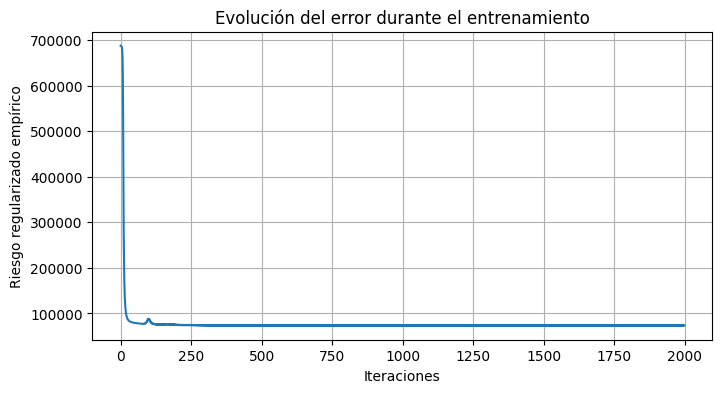

In [24]:
def entrenar_filtrado_colaborativo(Y, k=10, lambda_reg=10, lr=1e-3, num_iter=2000):
    """
    Entrena un modelo de filtrado colaborativo por factorización matricial con regularización L2.

    Args:
        Y (np.ndarray): matriz de calificaciones (n_items x n_users), con ceros donde no hay calificación.
        nu (int): dimensión del espacio latente (ν en la ecuación).
        lambda_reg (float): hiperparámetro de regularización (λ).
        lr (float): tasa de aprendizaje.
        num_iter (int): número de iteraciones de entrenamiento.

    Returns:
        X (np.ndarray): matriz de embeddings de ítems (n_items x ν).
        Theta (np.ndarray): matriz de embeddings de usuarios (n_users x ν).
        errores (list): evolución del error regularizado en cada iteración.
    """
    n_items, n_users = Y.shape
    X = np.random.normal(scale=0.1, size=(n_items, k))    # embeddings de ítems
    Theta = np.random.normal(scale=0.1, size=(n_users, k))  # embeddings de usuarios

    errores = []
    mask = Y > 0  # Solo se entrena con las observaciones existentes

    for it in range(num_iter):
        # Predicción y error solo en los valores observados
        Y_hat = X @ Theta.T
        error = (Y - Y_hat) * mask

        # Gradientes según la función de la filmina
        X_grad = -error @ Theta + lambda_reg * X
        Theta_grad = -error.T @ X + lambda_reg * Theta

        # Actualización de parámetros
        X -= lr * X_grad
        Theta -= lr * Theta_grad

        # Cálculo del riesgo regularizado
        loss = 0.5 * np.sum(error**2) + 0.5 * lambda_reg * (np.sum(X**2) + np.sum(Theta**2))
        errores.append(loss)

        if it % 100 == 0:
            print(f"Iteración {it}: Error = {loss:.2f}")

    return X, Theta, errores


# Entrenamiento

Y = df_actualizado.drop(columns=["Name"]).values.astype(float)

X, Theta, errores = entrenar_filtrado_colaborativo(Y=Y, k=10, lambda_reg=10, lr=1e-3, num_iter=2000)

# Gráfico
plt.figure(figsize=(8, 4))
plt.plot(errores)
plt.xlabel("Iteraciones")
plt.ylabel("Riesgo regularizado empírico")
plt.title("Evolución del error durante el entrenamiento")
plt.grid(True)
plt.show()


### Combinación de Predicciones del Modelo con la Calificación Promedio de Películas

Luego de entrenar el modelo de filtrado colaborativo mediante factorización matricial, se realiza una etapa de postprocesamiento para refinar las predicciones. Esta fase consiste en combinar la salida personalizada del modelo con la calificación promedio histórica de cada película, generando una predicción más equilibrada y robusta.

El procedimiento consta de los siguientes pasos:

1. **Cálculo de la predicción inicial (`R_hat`):**  
   Se genera la matriz de predicciones de calificaciones multiplicando los embeddings de ítems (`P`) por los embeddings de usuarios (`Q^T`):  
   $$
   \hat{R} = P Q^\top
   $$
   donde $ \hat{R}_{ij} $ representa la predicción del modelo para el ítem $ i $ y el usuario $ j $.

2. **Cálculo de la media por película ($ \mu_i $):**  
   Para cada ítem (película), se calcula su calificación promedio considerando únicamente las entradas observadas en la matriz original de ratings $ Y $. Es decir, para cada película $ i $, se tiene:  
   $$
   \mu_i = \frac{ \sum_{j: Y_{ij} \neq 0} Y_{ij} }{ \sum_{j} \mathbb{1}[Y_{ij} \neq 0] }
   $$
   donde $ \mathbb{1}[\cdot] $ es la función indicador que vale 1 si el usuario $ j $ calificó la película $ i $, y 0 en caso contrario.

3. **Expansión de la media ($ \mu $):**  
   Las medias por película se expanden a una matriz del mismo tamaño que $ \hat{R} $, replicando cada $ \mu_i $ a lo largo de todas las columnas (usuarios). Esto permite combinarlas fácilmente con la matriz de predicciones.

4. **Combinación de estimaciones (`R_final`):**  
   Finalmente, se obtiene una predicción híbrida promediando en partes iguales la salida del modelo y la media por película:  
   $$
   R_{\text{final}} = \frac{1}{2} \hat{R} + \frac{1}{2} \mu
   $$
   Esto permite suavizar las predicciones del modelo puro, especialmente cuando existen pocos datos o cuando el modelo presenta cierto sobreajuste.

Este enfoque de combinación es especialmente útil en sistemas de recomendación reales, donde las matrices de calificación suelen estar muy incompletas. Al incorporar una componente basada en popularidad (la media por ítem), se mejora la estabilidad de las predicciones y se compensa la incertidumbre en las regiones con menor densidad de datos.


In [33]:
# R: matriz de ratings original
# P, Q: matrices latentes entrenadas
R_hat = X @ Theta.T  # Predicción filtro colaborativo

# Calificación media por película (ignorando ceros)
media_peliculas = np.true_divide(Y.sum(axis=1), (Y != 0).sum(axis=1))

# Expandir la media para sumar con R_hat
media_expandida = np.tile(media_peliculas.reshape(-1, 1), (1, Y.shape[1]))

# Rating ponderado en partes iguales
R_final = 0.5 * R_hat + 0.5 * media_expandida


## **Sistema de recomendación**

En esta sección se implementa una función `recomendar_peliculas` que genera recomendaciones **personalizadas** para un usuario específico, basadas en una matriz de puntuaciones predichas. Este enfoque se apoya en la predicción de preferencias usando técnicas como **factores latentes** (por ejemplo, factorización matricial).

El objetivo es sugerir al usuario películas que aún no ha visto, pero que el sistema considera que le gustarán, basándose en patrones aprendidos de otros usuarios y películas.

### Parámetros de entrada

La función `recomendar_peliculas` recibe los siguientes argumentos:

- `nombre_usuario`: nombre del usuario al que se le harán las recomendaciones.
- `df_actualizado`: un `DataFrame` que contiene en la primera columna los nombres de las películas (`'Name'`) y en las columnas restantes, las puntuaciones de cada usuario.
- `R_final`: una matriz `numpy` con las puntuaciones predichas para cada combinación película-usuario.
- `Y`: una matriz binaria del mismo tamaño que `R_final`, donde `1` indica que el usuario ya vio la película y `0` que no la ha visto.
- `top_n`: cantidad de películas a recomendar (por defecto 5).

### Funcionamiento

1. **Verificación del usuario**: se comprueba que el nombre del usuario exista en el conjunto de datos.

2. **Índice del usuario**: se localiza la posición del usuario dentro de la matriz `R_final`.

3. **Predicciones y filtrado**:
   - Se extraen los **ratings predichos** para ese usuario.
   - Se identifica qué películas ya vio.
   - Se filtran las películas no vistas.

4. **Selección de recomendaciones**:
   - Se ordenan las películas no vistas según su puntuación predicha.
   - Se seleccionan las `top_n` películas con mayor puntuación.

5. **Salida**:
   - Se devuelven los nombres de las películas seleccionadas.
   - Si el usuario ya ha visto todas las películas, se informa con un mensaje correspondiente.

### Ejemplo de uso

Supongamos que el usuario `"usuario_nuevo"` no ha calificado muchas películas. Al ejecutar:

```python
recomendaciones = recomendar_peliculas("usuario_nuevo", df_actualizado, R_final, Y)

print("Top 5 recomendaciones:")
for i, peli in enumerate(recomendaciones, 1):
    print(f"{i}. {peli}")


In [34]:
def recomendar_peliculas(nombre_usuario, df_actualizado, R_final, Y, top_n=5):
    """
    Devuelve una lista con las top_n recomendaciones para un usuario.

    Parámetros:
    - nombre_usuario (str): Nombre del usuario.
    - df_actualizado (pd.DataFrame): DataFrame con la columna 'Name' y columnas de usuarios.
    - R_final (np.ndarray): Matriz de ratings predichos (películas x usuarios).
    - Y (np.ndarray): Matriz binaria de películas vistas (mismo orden que R_final).
    - top_n (int): Número de películas recomendadas a devolver.

    Retorna:
    - recomendaciones (list of str): Lista de nombres de películas recomendadas.
    """

    # Obtener solo las columnas de usuarios (excluye 'Name')
    nombres_usuarios = df_actualizado.columns[1:]

    if nombre_usuario not in nombres_usuarios:
        raise ValueError(f"Usuario '{nombre_usuario}' no encontrado.")

    # Índice del usuario en las matrices R_final y Y
    user_idx = nombres_usuarios.get_loc(nombre_usuario)

    # Ratings predichos
    user_ratings = R_final[:, user_idx]

    # Películas ya vistas
    vistas = Y[:, user_idx] > 0

    # Índices de películas no vistas
    no_vistas_indices = np.where(~vistas)[0]

    if len(no_vistas_indices) == 0:
        return ["El usuario ya ha visto todas las películas."]

    # Ratings de películas no vistas
    no_vistas_ratings = user_ratings[no_vistas_indices]

    # Top N recomendaciones
    top_indices = no_vistas_indices[np.argsort(no_vistas_ratings)[-top_n:][::-1]]

    # Obtener los nombres de las películas
    peliculas_names = df_actualizado['Name'].tolist()
    recomendaciones = [peliculas_names[i] for i in top_indices]

    return recomendaciones


recomendaciones = recomendar_peliculas("usuario_nuevo", df_actualizado, R_final, Y)

print("Top 5 recomendaciones:")
for i, peli in enumerate(recomendaciones, 1):
    print(f"{i}. {peli}")




Top 5 recomendaciones:
1.  Good Will Hunting (1997)
2.  Shawshank Redemption, The (1994)
3.  Schindler's List (1993)
4.  L.A. Confidential (1997)
5.  Usual Suspects, The (1995)
